# Converting Data into Well Format

While the next [example](./walrus_example_1_RunningWalrus.ipynb) shows how to use Walrus independently of our training code, our training and validation code will generally be easier to use if the data is formatted uniformly.

For this, we give an example of how you would take a non-Well dataset [Bubble ML 2.0](https://arxiv.org/abs/2507.21244) and convert it into the Well format. We're specifically looking at the PoolBoilSubcooled data for R515B and FC72 that we used in the Walrus paper. Note that since this is for usage in Walrus where our goal is to infer a number of properties from history, we don't try to map every property stored in the dataset to the new format - just the ones we need. **If you use the BubbleML dataset in your work in the transformed format, please cite their paper.** Their project also contains a number of interesting scenarios, tasks, and forms of analysis that weren't used in Walrus. 

To start off let's make some paths to store our raw and processed data, then we'll download the data. The files we're going to be downloading are quite large, so it may be better to download them through your preferred approach (manual, huggingface CLI, or other) and point processed path to the downloaded files. 

In [34]:
%matplotlib inline
import os 
import matplotlib.pyplot as plt

download_path = "./raw_data/"
processed_path = "./processed_data/"

os.makedirs(download_path, exist_ok=True)
os.makedirs(processed_path, exist_ok=True)


Note - this is a large dataset, so you may want to download it independently and just point `processed_path` at the download location.

In [ ]:
import requests
import os

os.makedirs(download_path, exist_ok=True)

# map each HF subfolder to a distinct local subpath
materials = {
    "PoolBoiling-Subcooled-R515B-2D": os.path.join(download_path, "R515B"),
    "PoolBoiling-Subcooled-FC72-2D":  os.path.join(download_path, "FC72"),
}

for material, subdir in materials.items():
    os.makedirs(subdir, exist_ok=True)
    api = f"https://huggingface.co/api/datasets/hpcforge/BubbleML_2/tree/main/{material}"
    resp = requests.get(api)
    resp.raise_for_status()
    items = resp.json()

    for item in items:
        path = item.get("path")
        if not path or item.get("type") != "file":
            continue
        url = f"https://huggingface.co/datasets/hpcforge/BubbleML_2/resolve/main/{path}"
        out_file = os.path.join(subdir, os.path.basename(path))
        if os.path.exists(out_file):
            print("skipping (exists):", out_file)
            continue
        print("downloading:", path, "->", out_file)
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(out_file, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        print("saved:", out_file)

If we look at the falls we've downloaded, we have a collection of HDF5 and json files. To see what we're trying to do, let's look at the structure of a Well-formatted file.

For helmholtz staircase, for example, the overall file structure looks like:
```
<KeysViewHDF5 ['boundary_conditions', 'dimensions', 'scalars', 't0_fields', 't1_fields', 't2_fields']>
{'dataset_name': 'helmholtz_staircase', 'grid_type': 'cartesian', 'n_spatial_dims': 2, 'n_trajectories': 26, 'omega': 0.06283032, 'simulation_parameters': array(['omega'], dtype=object)}
├── boundary_conditions
│   ├── x_open_neumann
│   │   └── mask (1024,)
│   ├── xy_wall
│   │   └── mask (1024, 256)
│   └── y_open_neumann
│       └── mask (256,)
├── dimensions
│   ├── time (50,)
│   ├── x (1024,)
│   └── y (256,)
├── scalars
│   └── omega ()
├── t0_fields
│   ├── mask (1024, 256)
│   ├── pressure_im (26, 50, 1024, 256)
│   └── pressure_re (26, 50, 1024, 256)
├── t1_fields
└── t2_fields
```
So for BubbleML data, we want to define these parameters based on the content of the HDF5 files and their associated metadata. We'll define a quick little helper to view this once we're done.


In [8]:
import h5py

def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
       
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + f'└── {key}')
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + f'└── {key} {val.shape}')
                except TypeError:
                    print(pre + f'└── {key} (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + f'├── {key}')
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + f'├── {key} {val.shape}')
                except TypeError:
                    print(pre + f'├── {key} (scalar)')

Now lets take a look at the file structure we have now:

In [12]:
# Let's look at an example json file
!cat {download_path}/Twall_100.json

{
    "geometry": "cartesian",
    "xl_boundary_type": "noslip_ins",
    "xr_boundary_type": "noslip_ins",
    "yl_boundary_type": "noslip_ins",
    "yr_boundary_type": "outflow_ins",
    "num_blocks_x": 32,
    "num_blocks_y": 32,
    "nx_block": "16",
    "ny_block": "16",
    "dt": 5.0,
    "t_initial": 0.0,
    "t_final": 200.0,
    "x_min": -8.0,
    "x_max": 8.0,
    "y_min": 0.0,
    "y_max": 16.0,
    "gravx": 0.0,
    "gravy": -1.0,
    "gravz": 0.0,
    "prandtl": 7.35,
    "inv_reynolds": 0.0043,
    "inflow_velscale": 1.0,
    "cpgas": 0.7997,
    "mugas": 0.02816,
    "rhogas": 0.008687,
    "thcogas": 0.209,
    "stefan": 0.6525,
    "heater": {
        "advAngle": 45.0,
        "nucWaitTime": 0.4,
        "rcdAngle": 45.0,
        "velContact": 0.2,
        "wallTemp": 100.0,
        "xMax": 5.25,
        "xMin": -5.25,
        "yMax": 9.9999998245167e-14,
        "yMin": 0.0,
        "zMax": 5.25,
        "zMin": -5.25
    },
    "nuc_seed_radii": [
        0.1000000014

In [14]:
# Now lets look at the HDF5
example_bubble = h5py.File(f"{download_path}/Twall_100.hdf5")
h5_tree(example_bubble)

├── dfun (2001, 512, 512)
├── massflux (2001, 512, 512)
├── normx (2001, 512, 512)
├── normy (2001, 512, 512)
├── pressure (2001, 512, 512)
├── temperature (2001, 512, 512)
├── velx (2001, 512, 512)
├── vely (2001, 512, 512)
├── x_centers (512,)
├── x_faces (513,)
├── y_centers (512,)
└── y_faces (513,)


We can see that this file appears to be one trajectory generated under a given configuration defined by the json file. The trajectory is 2001 steps long and contains snapshots from a 512x512 field which we will place at the volume centers. Trying to match the settings used in the Bubbleformer paper, we'll include dfun, temperature, and velocity in the new file. 

We won't try to include all of the information - Walrus is supposed to try to infer this from the history after all - but we'll add some of the high level details to the file as an example of how you would do this. 

One note here - for Euclidean data, the Well canonically stores data in [x, y, z] order. 2D images in Python are usually stored in [y, z] format, so we'll also want to transpose these axes to match other data.

We're going to declare the translation declaratively and in order to make the required tasks clear. 

Boundaries are the main tricky element - BubbleML uses no slip and outflow BCs. Since the Well uses topological descriptors of boundaries rather than explicit definitions, we need to map these to the Well's "open", "wall", and "periodic" descriptors. 
- No slip conditions models contact between a fluid and a solid surface. Since this indicates the presence of a barrier, this gets mapped to "wall"
- outflow BCs indicate that the flow can continue past this point. There is no barrier, simply an unknown extension of the domain beyond that point, so it is considered "open".

In [16]:
import glob
import json
import numpy as np

def translate_bubble(hdf5_path, json_path, subname, out_path):
    # velocity_x, velocity_y, pressure
    # Dims (t, y, x, c)
    baseT = int(hdf5_path.split('_')[-1].replace('.hdf5',''))
    json_file = json.load(open(json_path))
    # First lets extract the data we want from the HDF5
    with h5py.File(hdf5_path, 'r') as f:
        gas_interface_sdf = np.swapaxes(f['dfun'][:], 1, 2)[None]
        vx = np.swapaxes(f['velx'][:], 1, 2)[None]
        vy = np.swapaxes(f['vely'][:], 1, 2)[None]
        vel = np.stack([vx, vy], -1)
        temp = np.swapaxes(f['temperature'][:], 1, 2)[None]
        x_coords = f['x_centers'][:]
        y_coords = f['y_centers'][:]
        t = np.linspace(0, json_file["t_final"], 2001, endpoint=True)

    # Now we can create the new HDF5 file
    outpath = out_path + f"bubbleML_PoolBoiling-Subcooled_{subname}_T{baseT}.hdf5"
    with h5py.File(outpath, 'w') as f:
        # Base level
        f.attrs["dataset_name"] = f"bubbleML_PoolBoiling-Subcooled"
        f.attrs["grid_type"] = "cartesian" # Certain augmentations are only defined for certain grid types - otherwise this does not matter
        f.attrs["n_spatial_dims"] = 2 # Data is 2D
        f.attrs["n_trajectories"] = 1 # From viewing, we know each file is a single trajectory

        # Certain simulation parameter data is used in BubbleML benchmarks - lets make sure that data is available
        # [inv_reynolds, cpgas, mugas, rhogas, thcogas, stefan, prandtl, heater-nucWaitTime, heater-wallTemp]
        f.attrs["simulation_parameters"] = ["inv_reynolds", "cpgas", "mugas", "rhogas", "thcogas", "stefan", "prandtl", "heater-nucWaitTime", "heater-wallTemp"]
        f.attrs["inv_reynolds"] = json_file["inv_reynolds"]
        f.attrs["cpgas"] = json_file["cpgas"]
        f.attrs["mugas"] = json_file["mugas"]
        f.attrs["rhogas"] = json_file["rhogas"]
        f.attrs["thcogas"] = json_file["thcogas"]
        f.attrs["stefan"] = json_file["stefan"]
        f.attrs["prandtl"] = json_file["prandtl"]
        f.attrs["heater-nucWaitTime"] = json_file["heater"]["nucWaitTime"]
        f.attrs["heater-wallTemp"] = json_file["heater"]["wallTemp"]

        # Now lets move on to spatial dimensions
        dims = f.create_group("dimensions")
        dims.attrs["spatial_dims"] = ["x", "y"]
        time = dims.create_dataset("time", data=t)
        time.attrs["time_varying"] = True # This dimension (time) varies in time, but not in space
        time.attrs["sample_varying"] = False # All trajectories share the same time coordinates
        x = dims.create_dataset("x", data=x_coords)
        x.attrs["time_varying"] = False # Spatial dimensions do not vary in time. For a moving mesh, it would.
        x.attrs["sample_varying"] = False # All trajectories share the same spatial grid
        y = dims.create_dataset("y", data=y_coords)
        y.attrs["time_varying"] = False
        y.attrs["sample_varying"] = False

        # Boundaries
        boundaries = f.create_group("boundary_conditions")
        # We have walls on either side, so create "WALL" conditions at both first and last indices
        x_wall_noslip = boundaries.create_group("x_wall_noslip")
        xmask = np.zeros(x_coords.shape[0])
        xmask[0] = 1
        xmask[-1] = 1
        x_wall_noslip.create_dataset("mask", data=xmask, dtype=np.int8)
        x_wall_noslip.attrs["bc_type"] = "WALL"
        x_wall_noslip.attrs["associated_dims"] = ["x"]
        x_wall_noslip.attrs["associated_fields"] = []
        x_wall_noslip.attrs["sample_varying"] = False
        x_wall_noslip.attrs["time_varying"] = False
        # In "y", we have an open top and wall bottom
        y_wall_noslip = boundaries.create_group("y_wall_noslip")
        ymask = np.zeros(y_coords.shape[0])
        ymask[0] = 1
        y_wall_noslip.create_dataset("mask", data=ymask, dtype=np.int8)
        y_wall_noslip.attrs["bc_type"] = "WALL"
        y_wall_noslip.attrs["associated_dims"] = ["y"]
        y_wall_noslip.attrs["associated_fields"] = []
        y_wall_noslip.attrs["sample_varying"] = False
        y_wall_noslip.attrs["time_varying"] = False

        y_open = boundaries.create_group("y_open")
        ymask = np.zeros(y_coords.shape[0])
        ymask[-1] = 1
        y_open.create_dataset("mask", data=ymask, dtype=np.int8)
        y_open.attrs["bc_type"] = "OPEN"
        y_open.attrs["associated_dims"] = ["y"]
        y_open.attrs["associated_fields"] = []
        y_open.attrs["sample_varying"] = False
        y_open.attrs["time_varying"] = False

        # Now we can add scalars - for most cases in this codebase, these are unused metadata. 
        # Scalars
        scalars = f.create_group("scalars")
        scalars.attrs["field_names"] = ["inv_reynolds", "cpgas", "mugas", "rhogas", "thcogas", "stefan", "prandtl", "heater-nucWaitTime", "heater-wallTemp"]
        omega = scalars.create_dataset("inv_reynolds", data=json_file["inv_reynolds"])
        omega.attrs["sample_varying"] = False
        omega.attrs["time_varying"] = False

        cpgas = scalars.create_dataset("cpgas", data=json_file["cpgas"])
        cpgas.attrs["sample_varying"] = False
        cpgas.attrs["time_varying"] = False

        mugas = scalars.create_dataset("mugas", data=json_file["mugas"])
        mugas.attrs["sample_varying"] = False
        mugas.attrs["time_varying"] = False

        rhogas = scalars.create_dataset("rhogas", data=json_file["rhogas"])
        rhogas.attrs["sample_varying"] = False
        rhogas.attrs["time_varying"] = False

        thcogas = scalars.create_dataset("thcogas", data=json_file["thcogas"])
        thcogas.attrs["sample_varying"] = False
        thcogas.attrs["time_varying"] = False

        stefan = scalars.create_dataset("stefan", data=json_file["stefan"])
        stefan.attrs["sample_varying"] = False
        stefan.attrs["time_varying"] = False

        prandtl = scalars.create_dataset("prandtl", data=json_file["prandtl"])
        prandtl.attrs["sample_varying"] = False
        prandtl.attrs["time_varying"] = False

        heater_nucWaitTime = scalars.create_dataset("heater-nucWaitTime", data=json_file["heater"]["nucWaitTime"])
        heater_nucWaitTime.attrs["sample_varying"] = False
        heater_nucWaitTime.attrs["time_varying"] = False

        heater_wallTemp = scalars.create_dataset("heater-wallTemp", data=json_file["heater"]["wallTemp"])
        heater_wallTemp.attrs["sample_varying"] = False
        heater_wallTemp.attrs["time_varying"] = False

        # Fields - this is the most important part - this is the data we are actually modeling. 
        t0 = f.create_group("t0_fields") # t0 indicates spatially varying scalar fields. 

        # We have two of these, the sdf of the gas-liquid interface, and the temperature field
        t0.attrs["field_names"] = ["gas-interface-sdf", "temperature"] 
        m = t0.create_dataset("gas-interface-sdf", data=gas_interface_sdf, dtype=np.float32)
        m.attrs["dim_varying"] = np.array([True, True]) # This field is defined over both spatial dims (ie, shape is ... X Y)
        m.attrs["sample_varying"] = True # This field varies between trajectories, so shape is now (trajectory, ..., X, Y)
        m.attrs["time_varying"] = True # This field varies over time, so shape is now (trajectory, time X, Y)

        temp_dset = t0.create_dataset("temperature", data=temp, dtype=np.float32)
        temp_dset.attrs["dim_varying"] = np.array([True, True])
        temp_dset.attrs["sample_varying"] = True
        temp_dset.attrs["time_varying"] = True

        # Tensor-valued fields (vector in this case), have d components per spatial location
        # so now for fully varying fields, the shape is (trajectory, time, X, Y, d)
        t1 = f.create_group("t1_fields")
        t1.attrs["field_names"] = ["velocity"]
        v = t1.create_dataset("velocity", data=vel, dtype=np.float32)
        v.attrs["dim_varying"] = np.array([True, True])
        v.attrs["sample_varying"] = True
        v.attrs["time_varying"] = True

        # We don't have any 2-tensor fields in this dataset, but for completeness, create the group
        # These would be shape (trajectory, time, X, Y, d, d)
        t2 = f.create_group("t2_fields")
        t2.attrs["field_names"] = []


Now that we have our files and our transformation definition, lets use them!

In [20]:
# Clean up first
!rm -Rf {processed_path}/data/

!mkdir {processed_path}/data/
!mkdir {processed_path}/data/train/
!mkdir {processed_path}/data/valid/
!mkdir {processed_path}/data/test/

materials = [
    "FC72",
      "R515B",
        ]
for material in materials:
  base_path = os.path.join(download_path, material)
  out_path = f"{processed_path}/data/train/"
  files = glob.glob(base_path + '/*.hdf5')
  count = 0
  for file in files:
      hdf5_path = file
      json_path = file.replace('.hdf5', '.json')
      translate_bubble(hdf5_path, json_path, material, out_path)
      print(os.path.exists(hdf5_path), os.path.exists(json_path))

True True
True True


The files should now be transformed! The problem now is we don't have a valid and test set. In the experiments in their paper, only 2 sets were used, so we'll repeat this pattern here. If you're doing a lot of HP tuning on validation, you'll generally want to avoid this pattern, but we're going to use it here to match the original settings.

In [ ]:
valid_files = ["bubbleML_PoolBoiling-Subcooled_FC72_T107.hdf5", 
               "bubbleML_PoolBoiling-Subcooled_FC72_T97.hdf5",
                 "bubbleML_PoolBoiling-Subcooled_R515B_T30.hdf5", 
                 "bubbleML_PoolBoiling-Subcooled_R515B_T40.hdf5"]
test_files = ["bubbleML_PoolBoiling-Subcooled_FC72_T107.hdf5", 
              "bubbleML_PoolBoiling-Subcooled_FC72_T97.hdf5", 
              "bubbleML_PoolBoiling-Subcooled_R515B_T30.hdf5", 
              "bubbleML_PoolBoiling-Subcooled_R515B_T40.hdf5"]

# Now move validation and test files to their folders 
for vf in valid_files:
    !mv {processed_path}/data/train/{vf} {processed_path}/data/valid/{vf}
for tf in test_files:
    !cp {processed_path}/data/valid/{tf} {processed_path}/data/test/{tf}

Perfect. The Well contains a number of utilities to help verify transformed data. In particular, there is the [format checker tool](https://github.com/PolymathicAI/the_well/blob/master/scripts/check_thewell_formatting.py). 

However, here we're going to assume the formatting is OK and see how we could then use the data.

In [26]:
from walrus.data.inflated_dataset import BatchInflatedWellDataset


dataset = BatchInflatedWellDataset(path=f"{processed_path}",
                                   well_split_name="train",
                                   normalization_type=None)

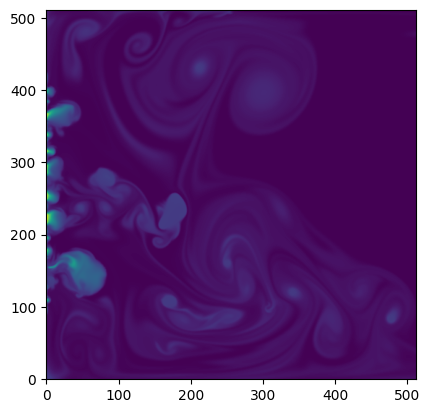

In [38]:
import matplotlib.pyplot as plt

samples = dataset[1000]
temperature = samples["input_fields"][0, ..., 1].squeeze()
img = plt.imshow(temperature, origin='lower')
plt.show()

To see how you'd use this in a Walrus model, check out the next [notebook](walrus_example_1_RunningWalrus.ipynb).

To see how you'd define a config file around this for use in the full Walrus codebase, check out the config file [here](https://github.com/PolymathicAI/walrus/blob/walrus/configs/data/bubbleml_poolboil_subcool.yaml). 